# Analysis & Comparison 

## Libraries 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Data set 

In [4]:
#file = 'Data/data.csv'
file = 'Data/new_dataset_clean.csv'
dataframe = pd.read_csv(file, error_bad_lines=False, sep=";")
df = dataframe.copy()
print("Data set's shape = ", df.shape) 
print("There is {} missing values in the target".format(df['Label'].isnull().sum()))

Data set's shape =  (43721, 2)
There is 0 missing values in the target


In [4]:
df.tail(7)

,Tweets,Label
43714,you're all niggers,1
43715,you're such a retard i hope you get type 2 dia...,1
43716,you's a muthaf***in lie right his tl is tr...,1
43717,you've gone and broke the wrong hea baby and ...,0
43718,young buck wanna eat dat nigguh like i aint fu...,1
43719,youu got wild bitches tellin you lies,1
43720,ruffled ntac eileen dahlia beautiful color c...,0


# Canonization : Lemmatization vs Stemming

### Number of Tokens per canonization method (100% of data set)

In [13]:
from DPreprocessing import canonization
nbr_lemmatized_tokens = len(canonization(df['Tweets'], method="lemmatization"))
nbr_stemmed_tokens = len(canonization(df['Tweets'], method="stemming"))

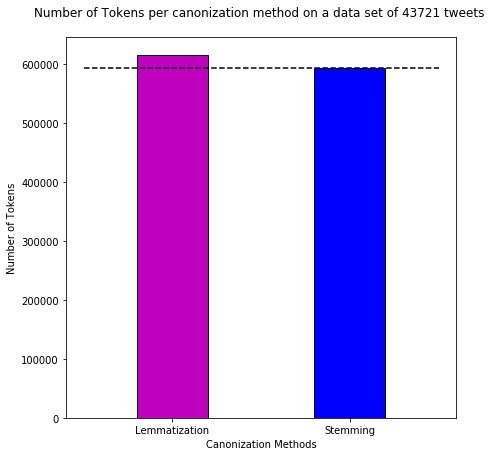

In [73]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(7,7))
methods = ["Lemmatization","Stemming"]
nbr_tokens = [nbr_lemmatized_tokens, nbr_stemmed_tokens]
plt.bar(methods, nbr_tokens, width=0.4, color=['m','b'], edgecolor='black')
plt.hlines(nbr_tokens[1], -0.5, 1.5, colors='k', linestyles='dashed')
plt.xlabel("Canonization Methods")
plt.ylabel("Number of Tokens")
plt.title("Number of Tokens per canonization method on a data set of {} tweets \n".format(df.shape[0]))
plt.show()

### Most frequent tokens after Lemmatization & Stemming (10'000 exp from data set)

In [5]:
%%time
from DPreprocessing import data_cleaning, canonization, stop_words, balanced_sample

data = balanced_sample(df,10000)
cleaned_data = data_cleaning(data)
lemmatized_tokens = stop_words(canonization(cleaned_data['Tweets'],method="lemmatization"))
stemmed_tokens = stop_words(canonization(cleaned_data['Tweets'],method="stemming"))

CPU times: user 1min 34s, sys: 6.66 s, total: 1min 41s
Wall time: 1min 41s


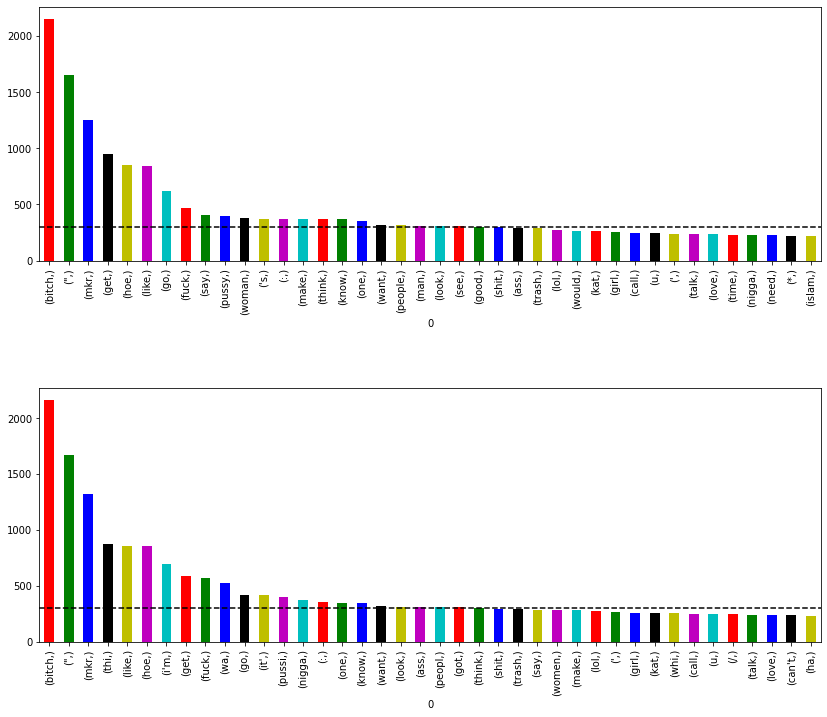

In [21]:
import matplotlib.pyplot as plt 

colors_list = list('rgbkymc')
fig, ax = plt.subplots(2,1, figsize=(14,9))

pd.DataFrame(lemmatized_tokens).value_counts()[:40].plot(kind='bar', color=colors_list, ax=ax[0])
ax[0].hlines(300, -0.5, 40, colors='k', linestyles='dashed')

pd.DataFrame(stemmed_tokens).value_counts()[:40].plot(kind='bar', color=colors_list, ax=ax[1])
ax[1].hlines(300, -0.5, 40, colors='k', linestyles='dashed')

plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)
plt.show()

### Evaluation of Lemmatization & Stemming (10'000 exp from data set)

In [264]:
%%time
from DPreprocessing import preprocessing 
from Models import support_vector_machine 

data = balanced_sample(df,10000)

# Lemmatization 
X_train, X_test, y_train, y_test = preprocessing(data, nbr_tokens=100, vectorizer="bow", canon="lemmatization")
f1_score_lemma = support_vector_machine(X_train, X_test, y_train, y_test, metric="f1score")
accuracy_lemma = support_vector_machine(X_train, X_test, y_train, y_test, metric="accuracy")

# Stemming 
X_train, X_test, y_train, y_test = preprocessing(data, nbr_tokens=100, vectorizer="bow", canon="stemming")
f1_score_stem = support_vector_machine(X_train, X_test, y_train, y_test, metric="f1score")
accuracy_stem = support_vector_machine(X_train, X_test, y_train, y_test, metric="accuracy")


>>> Copy data set
>>> Preprocessing start
>>> Data cleaned 
>>> Canonization done
>>> Vectorization done
>>> Split Data done 
>>> End of Preprocessing
>>> Copy data set
>>> Preprocessing start
>>> Data cleaned 
>>> Canonization done
>>> Vectorization done
>>> Split Data done 
>>> End of Preprocessing
CPU times: user 1min 26s, sys: 1.3 s, total: 1min 27s
Wall time: 1min 29s


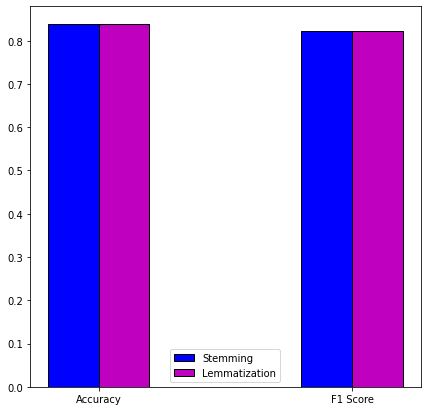

In [266]:
from Evaluations import metrics_graphic 

lemmatization_metrics = [accuracy_lemma,f1_score_lemma]
stemming_metrics = [accuracy_stem,f1_score_stem]

metrics_graphic(stemming_metrics, lemmatization_metrics)

## Tweets length 

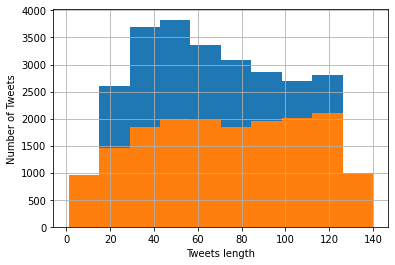

In [267]:
#h = 'step'
df['Tweets'][df['Label']==1].str.len().hist()#histtype=h)
df['Tweets'][df['Label']==0].str.len().hist()#histtype=h)
plt.xlabel('Tweets length')
plt.ylabel('Number of Tweets')
plt.show()

In [18]:
# Build a function that returns the length of each tweet 
def len_tweets(tweets):
    length = []
    for tweet in tweets:
        length.append(len(tweet))
    return pd.DataFrame(length)

## Shallow parsing (Chunking)

In [67]:
import spacy 
nlp = spacy.load('en_core_web_sm')

**Noun phrase extraction**

In [221]:
def tweet_noun_chunks(tweets):
    '''
        This function generates a list of noun chunks who's tokens are not in stopwords list 
    '''
    from nltk.corpus import stopwords
    
    tweets_noun_chunks = []
    for tweet in tweets:
        doc = nlp(tweet)
        for chunk in doc.noun_chunks: 
            if len(str(chunk).split())>1 and any(word in str(chunk).split() for word in stopwords.words('english'))==False:
                #print(">>>>> ", chunk) 
                tweets_noun_chunks.append(chunk.text.strip())
    return tweets_noun_chunks    

In [222]:
%%time
# noun chunks + stop words 
from DPreprocessing import stop_words 
tweet_noun_chunks = tweet_noun_chunks(cleaned_data['Tweets'])

CPU times: user 1min 9s, sys: 1.06 s, total: 1min 10s
Wall time: 1min 10s


<AxesSubplot:xlabel='0'>

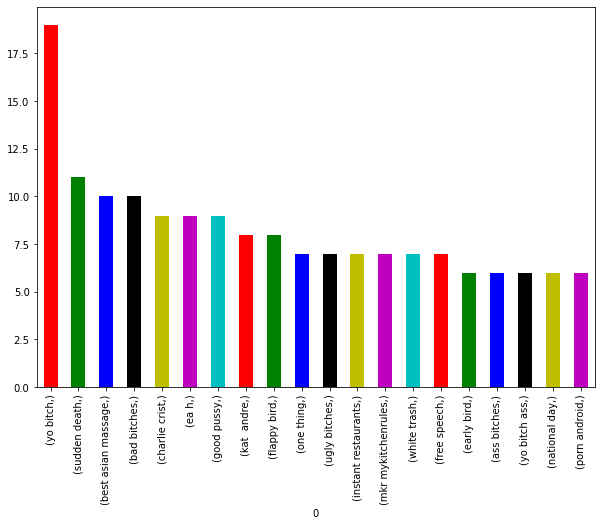

In [220]:
plt.figure(figsize=(10,7))
colors_list = list('rgbkymc')
pd.DataFrame(tweet_noun_chunks).value_counts()[:20].plot(kind='bar', color=colors_list)

**Verb phrases extraction**

## Named-Entity Recognition (NER)

In [95]:
def named_entity_recognition(tweets):    
    nlp = spacy.load('en_core_web_sm')
    bloc = []
    for tweet in tweets: 
        doc = nlp(tweet)
        for ent in doc.ents:
            bloc.append([ent.text, ent.label_])
    return bloc

In [102]:
%%time
from DPreprocessing import data_cleaning 
import spacy
dataf = data_cleaning(df)
ner = named_entity_recognition(dataf['Tweets'])

CPU times: user 4min 38s, sys: 1.75 s, total: 4min 40s
Wall time: 4min 42s


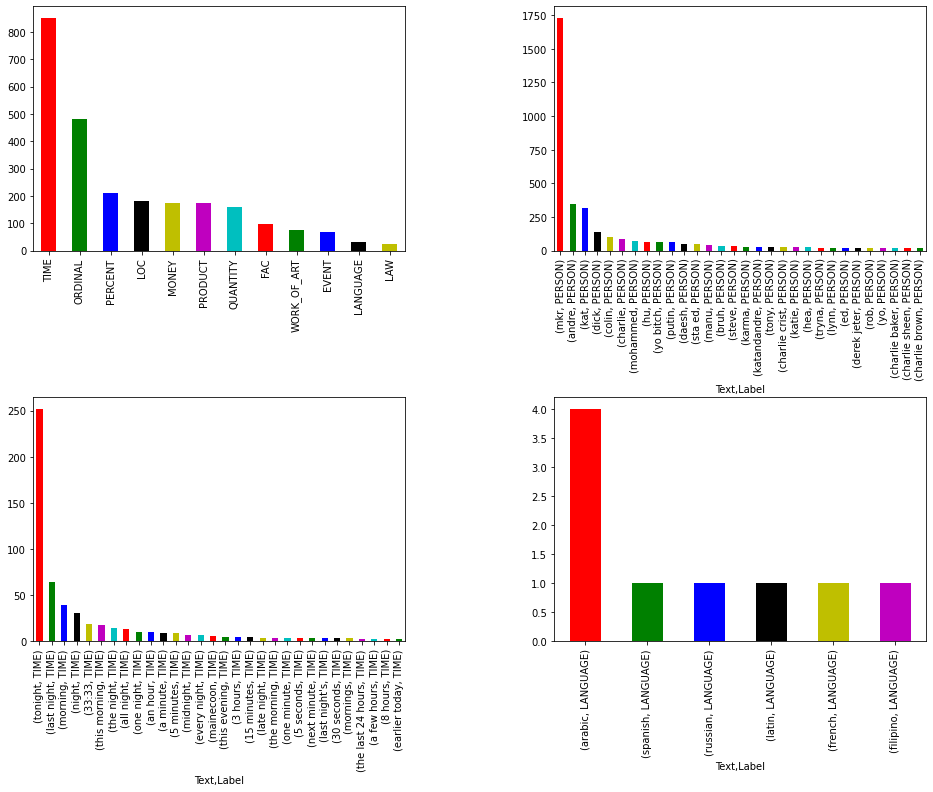

In [112]:
import matplotlib.pyplot as plt 

colors_list = list('rgbkymc')
NER = pd.DataFrame(ner,columns=['Text','Label'])

fig, ax = plt.subplots(2,2, figsize=(16,9))

# All labels 
NER['Label'].value_counts()[6:].plot(kind='bar', color=colors_list, ax=ax[0,0])

# Person
NER[NER['Label']=="PERSON"].value_counts()[:30].plot(kind='bar', color=colors_list, ax=ax[0,1])

# Organizations
NER[NER['Label']=="TIME"].value_counts()[:30].plot(kind='bar', color=colors_list, ax=ax[1,0])

# Ordinal 
NER[NER['Label']=="LANGUAGE"].value_counts()[1:20].plot(kind='bar', color=colors_list, ax=ax[1,1])



plt.subplots_adjust(top = 1.0, bottom=0.02, hspace=0.6, wspace=0.4)
plt.show()

## N-Gram Extraction 

In [52]:
from sklearn.feature_extraction import text 

offensive_words = ['bitch','bit','fuck','pussy','hoe']
my_additional_stop_words = []
my_additional_stop_words.extend(offensive_words)
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

In [53]:
def ngram(tweets, nbr_gram, stopwords):
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer(max_features=None, 
                                stop_words=stopwords,
                                ngram_range = (nbr_gram,nbr_gram)
                                )
    vectorizer.fit(tweets)
    vocab = list(vectorizer.vocabulary_.keys())
    
    return vocab 

In [54]:
def ngrams_frequency(tweets, grams):
    
    # all tweets in one single string 
    all_tweets = tweets.sum(axis=0)
    
    ngrams_frequency = []
    for gram in grams:
        ngrams_frequency.append([gram,all_tweets.count(gram)])
    
    matrix = pd.DataFrame(ngrams_frequency,columns=['Gram','Frequencies'])
    matrix.sort_values(by='Frequencies', ascending=False, inplace=True)
    return matrix

In [55]:
def generate_ngram_file(file,ngram_frequency):
    with open(file, 'w') as f:
        for item in ngram_frequency:
            f.write("%s\n" % item)
    print("The file is ready !")

In [56]:
# data set for n-gram extraction 
from DPreprocessing import data_cleaning 
dataf = data_cleaning(df)

**1-Gram**

In [57]:
%%time
onegram_list = ngram(tweets=dataf['Tweets'], nbr_gram=1, stopwords=stop_words)
onegram_frequency = ngrams_frequency(tweets=dataf['Tweets'], grams=onegram_list)

CPU times: user 2min 35s, sys: 29.2 s, total: 3min 4s
Wall time: 3min 5s


In [63]:
generate_ngram_file(file='one_grams.txt', ngram_frequency=onegram_frequency['Gram'])

The file is ready !


<AxesSubplot:xlabel='Gram'>

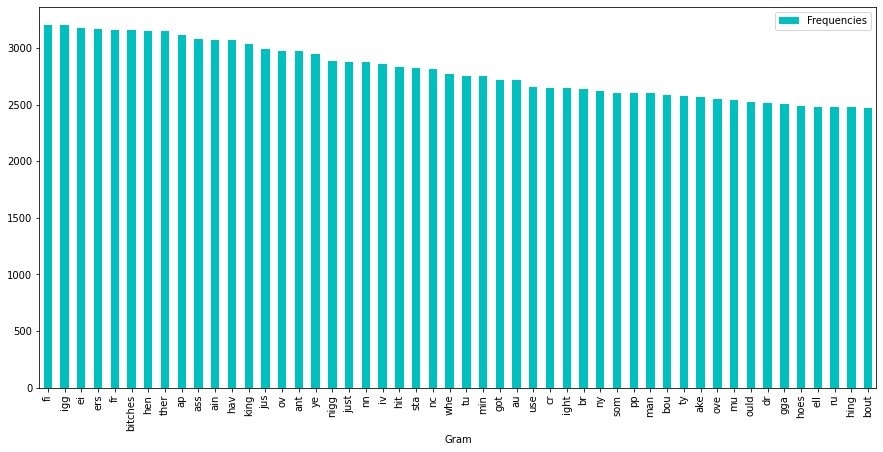

In [59]:
onegram_frequency[150:200].plot(x='Gram',y='Frequencies', kind='bar', color='c', figsize=(15,7))

**2-Gram**

In [81]:
%%time
twogram_list = ngram(tweets=dataf['Tweets'], nbr_gram=2, stopwords=stop_words)
twogram_frequency = ngrams_frequency(tweets=dataf['Tweets'], grams=twogram_list)

CPU times: user 9min 40s, sys: 31 s, total: 10min 11s
Wall time: 10min 19s


In [82]:
generate_ngram_file(file='two_grams.txt', ngram_frequency=twogram_frequency['Gram'])

The file is ready !


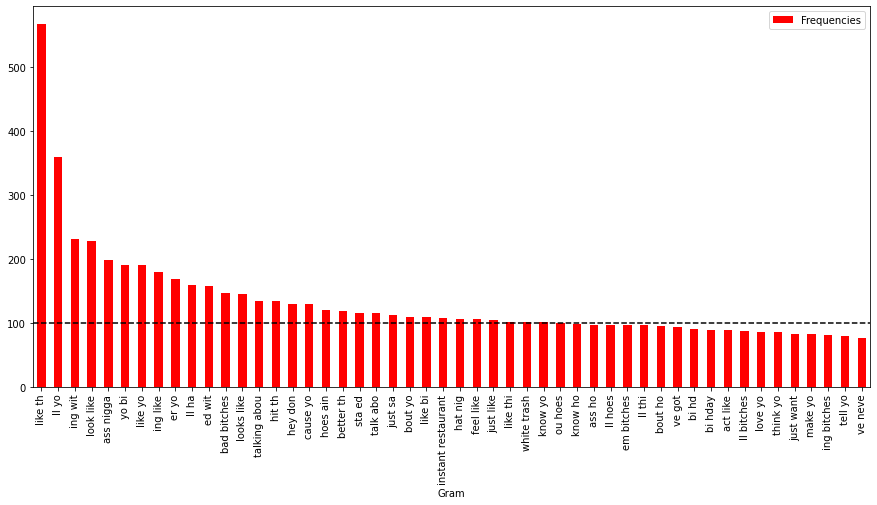

In [92]:
twogram_frequency[:50].plot(x='Gram',y='Frequencies', kind='bar', color='r', figsize=(15,7))
plt.hlines(100, -0.5, 50, colors='k', linestyles='dashed')

**3-Gram**

In [85]:
%%time
threegram_list = ngram(tweets=dataf['Tweets'], nbr_gram=3, stopwords=stop_words)
threegram_frequency = ngrams_frequency(tweets=dataf['Tweets'], grams=threegram_list)

CPU times: user 8min 56s, sys: 31.6 s, total: 9min 28s
Wall time: 9min 35s


In [86]:
generate_ngram_file(file='three_grams.txt', ngram_frequency=threegram_frequency['Gram'])

The file is ready !


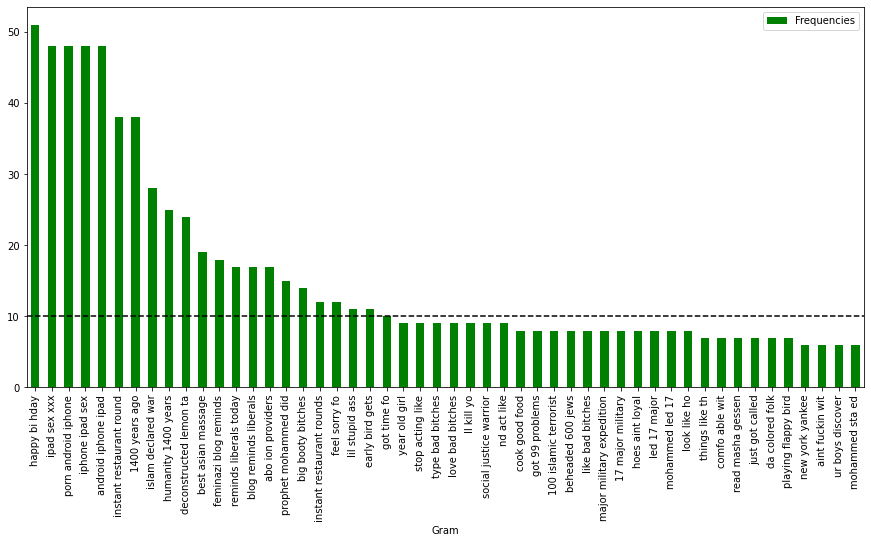

In [90]:
threegram_frequency[:50].plot(x='Gram',y='Frequencies', kind='bar', color='g', figsize=(15,7))
plt.hlines(10, -0.5, 50, colors='k', linestyles='dashed')

## Polarity 

**100% of data set**

In [22]:
def polarity(tweets):
    from textblob import TextBlob
    polarity = []
    for tweet in tweets: 
        pol = TextBlob(tweet)
        polarity.append(pol.sentiment.polarity)
    return pd.DataFrame(polarity)

In [282]:
discriminant_tweets_polarity = polarity(df['Tweets'][df['Label']==1.0])
non_discriminant_tweets_polarity = polarity(df['Tweets'][df['Label']==0.0])

<AxesSubplot:ylabel='Frequency'>

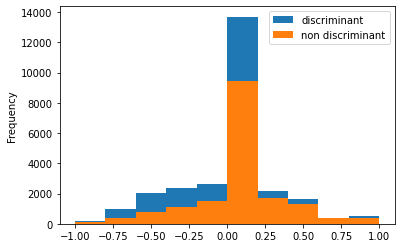

In [303]:
tweets_polarity = pd.concat([discriminant_tweets_polarity,non_discriminant_tweets_polarity], axis=1)
tweets_polarity.columns = ['discriminant','non discriminant']
tweets_polarity.plot.hist()

## Features Extraction 

In [13]:
features_from_chunking    = ['white trash']
features_from_one_grams   = ['nigga','mohammed','jew','prophet','muslim','isis','murder','muslims','islam']
features_from_two_grams   = ['stop bein','prophet mohammed','sudden death','declared war','1400 years','pedophile prophet']
features_from_three_grams = ['1400 years ago','islam declared war','humanity 1400 years','prophet mohammed did','feminazi blog reminds']
features_from_ner         = ['raqqa','taliban','mohammed','daesh','gitmo jihadi','mosque']

In [14]:
new_features = list(set(features_from_chunking)   |
                   set(features_from_one_grams)   |
                   set(features_from_two_grams)   |
                   set(features_from_three_grams) |
                   set(features_from_ner))

In [15]:
def newfeatures(newf, tweets):
    matrix = []
    for tweet in tweets:
        values = []
        for feature in newf:
            if feature in tweet: values.append(1)
            else: values.append(0)
        matrix.append(values)
    return pd.DataFrame(matrix, columns=newf)

**Features from Chunking, N-Grams and NER**

In [20]:
additionnal_features = newfeatures(newf=new_features, tweets=data['Tweets'])

**Tweet length feature**

In [21]:
tweet_length = len_tweets(data['Tweets'])  

**Tweets Polarity feature**

In [23]:
tweet_polarity = polarity(data['Tweets'])

## Results on 10'000 tweets 

In [5]:
from DPreprocessing import balanced_sample
data = balanced_sample(df,10000)

**Lemmatization POS + BOW**

In [6]:
%%time
from DPreprocessing import preprocessing 
from Models import support_vector_machine 

X_train, X_test, y_train, y_test = preprocessing(data, nbr_tokens=100, vectorizer="bow", canon="lemmatization")
f1_score_m1 = support_vector_machine(X_train, X_test, y_train, y_test, metric="f1score")
accuracy_m1 = support_vector_machine(X_train, X_test, y_train, y_test, metric="accuracy")

>>> Copy data set
>>> Preprocessing start
>>> Data cleaned 
>>> Canonization done
>>> Vectorization done
>>> Split Data done 
>>>>>>>>>>>>>>> End of Preprocessing
CPU times: user 1min 20s, sys: 2.01 s, total: 1min 22s
Wall time: 1min 42s


**Stemming + BOW**

In [7]:
%%time
from DPreprocessing import preprocessing 
from Models import support_vector_machine 

X_train, X_test, y_train, y_test = preprocessing(data, nbr_tokens=100, vectorizer="bow", canon="stemming")
f1_score_m2 = support_vector_machine(X_train, X_test, y_train, y_test, metric="f1score")
accuracy_m2 = support_vector_machine(X_train, X_test, y_train, y_test, metric="accuracy")

>>> Copy data set
>>> Preprocessing start
>>> Data cleaned 
>>> Canonization done
>>> Vectorization done
>>> Split Data done 
>>>>>>>>>>>>>>> End of Preprocessing
CPU times: user 9.78 s, sys: 188 ms, total: 9.97 s
Wall time: 10.2 s


**TF-IDF**

In [60]:
%%time
from DPreprocessing import preprocessing 
from Models import support_vector_machine 

X_train, X_test, y_train, y_test = preprocessing(data, nbr_tokens=100, vectorizer="tfidf", canon="stemming")
f1_score_m3 = support_vector_machine(X_train, X_test, y_train, y_test, metric="f1score")
accuracy_m3 = support_vector_machine(X_train, X_test, y_train, y_test, metric="accuracy")

>>> Copy data set
>>> Preprocessing start
>>> Data cleaned 
>>> Canonization done
>>> Vectorization done
>>> Split Data done 
>>>>>>>>>>>>>>> End of Preprocessing
CPU times: user 10 s, sys: 163 ms, total: 10.2 s
Wall time: 10.3 s


**Hashing**

In [63]:
%%time
from DPreprocessing import preprocessing 
from Models import support_vector_machine 

X_train, X_test, y_train, y_test = preprocessing(data, nbr_tokens=100, vectorizer="hashing", canon="stemming")
f1_score_m4 = support_vector_machine(X_train, X_test, y_train, y_test, metric="f1score")
accuracy_m4 = support_vector_machine(X_train, X_test, y_train, y_test, metric="accuracy")

>>> Copy data set
>>> Preprocessing start
>>> Data cleaned 
>>> Canonization done
>>> Vectorization done
>>> Split Data done 
>>>>>>>>>>>>>>> End of Preprocessing
CPU times: user 14.6 s, sys: 116 ms, total: 14.7 s
Wall time: 14.8 s


**Lemmatization POS + BOW + Feature Extraction**

In [29]:
%%time
from DPreprocessing import data_cleaning, canonization
from Vectorizer import vectorization

cleaned_data = data_cleaning(data)
tokens = canonization(cleaned_data['Tweets'], method="lemmatization")
X = vectorization(cleaned_data, nbr_tokens=100, tokens=tokens, method="bow")
newX = pd.concat([X,additionnal_features,tweet_length,tweet_polarity])

from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)

CPU times: user 1min 4s, sys: 422 ms, total: 1min 4s
Wall time: 1min 4s


In [44]:
tweet_polarity = polarity(cleaned_data['Tweets'])
tweet_polarity
#new = pd.concat([tweet_polarity,X], axis=1)
#new.columns=[tweet_polarity.columns,X.columns]
#new
[["polarity",X.columns]]

[['polarity',
  Index(['didn', 'love', 'muslims', 'day', 'thing', 'stop', 'bitches', 'bitch',
         'just', 'islam', 'want', 'fucking', 'dick', 'pussy', 'ass', 'sexist',
         'women', 'big', 'tell', 'shit', 'got', 'good', 'real', 'oh', 'really',
         'yeah', 'little', 'think', 'game', 'lol', 'know', 'wanna', 'look',
         'man', 'woman', 'life', 'doing', 'going', 'like', 'said', 'old', 'make',
         'mkr', 'don', 'hate', 'getting', 'money', 'nigga', 'talk', 'did',
         'better', 'time', 'niggas', 'way', 've', 'im', 'let', 'lmao', 'fuck',
         'hoe', 'talking', 'hoes', 'yo', 'girls', 'today', 'right', 'stupid',
         'new', 'need', 'feminazi', 'bird', 'twitter', 'doesn', 'muslim', 'does',
         'isis', 'bad', 'things', 'sta', 'yes', 'say', 'll', 'best', 'girl',
         'ain', 'use', 'ya', 'men', 'god', 'pretty', 'come', 'trash', 'people',
         'gonna', 'white', 'kat', 'mkr2015', 'pa', 'andre', 'charlie'],
        dtype='object')]]

**TF-IDF + Feature Extraction**

**Hashing + Feature Extraction**

**METHODS**

In [64]:
m1 = ["Lemmatization POS + BOW ",accuracy_m1,f1_score_m1]
m2 = ["Stemming + BOW ",accuracy_m2,f1_score_m2]
m3 = ["TF-IDF",accuracy_m3,f1_score_m3]
m4 = ["Hashing",accuracy_m4,f1_score_m4]
m5 = ["Lemmatization POS + BOW + Feature Extraction"]
m6 = ["TF-IDF + Feature Extraction"]
m7 = ["Hashing + Feature Extraction"]
# ++ PCA 

**RESULTS (Model : SVM)**

In [47]:
def results(*args):
    '''
        [Method,Accuracy,F1Score]
    '''
    
    methods_results = []
    for method in args:
        methods_results.append(method)
    return pd.DataFrame(methods_results,columns=["Methods","Accuracy","F1 Score"]) 

In [65]:
results(m1,m2,m3,m4)

,Methods,Accuracy,F1 Score
0,Lemmatization POS + BOW,0.827333,0.810117
1,Stemming + BOW,0.827333,0.810117
2,TF-IDF,0.830333,0.815111
3,Hashing,0.700000,0.679030
